In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector,SelectFromModel
from sklearn.linear_model import LinearRegression,Ridge,Lasso #Ridge: Regularisasi L2 (cegah satu fitur untuk punya efek dominan), Lasso: regularisasi L1, regularisasi biasa
from sklearn.tree import DecisionTreeRegressor #Tree model untuk regresi
from sklearn.ensemble import RandomForestRegressor #Random forest
from sklearn.metrics import mean_squared_error,r2_score

# Main objectives



*   Feature selection if enabled
*   Quickly load data, train average price prediction them on few types of models.
*   Plot performance



In [ ]:
#sequential feature selection, seleksi feature yang berguna buat suatu model.
def sequential_feature_selection(model,X_train,Y_train,X_test):
    sfs = SequentialFeatureSelector(model,  direction='backward', scoring='r2', cv=5)
    sfs.fit(X_train, Y_train)
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    return X_train_selected, X_test_selected

In [ ]:
#Fungsi untuk membuat data parameter Gradient Boost Regressor
def GBParamBuilder(n_estimator=500, max_depth=4, min_sample_split=5, lr=0.01, loss="squared_error"):
  return params = {
    "n_estimators": n_estimator,
    "max_depth": max_depth,
    "min_samples_split": min_sample_split,
    "learning_rate": lr,
    "loss": loss,
}

## Trees & Ensemble

In [ ]:
def GBRTrain(X, y, params ): #Gradient Boost Regressor
  model = ensemble.GradientBoostingRegressor(**params)
  model.fit(X,y)
  return model
def RFRTrain(X, y, n_estimator, max_depth ): #Random Forest Regressor
  model = RandomForestRegressor(n_estimators=n_estimator, max_depth=max_depth)
  model.fit(X,y)
  return model
def DTRTrain(X, y): #Decision Tree Regressor
  model = DecisionTreeRegressor()
  model.fit(X,y)
  return model

## Regression

In [ ]:
def LTrain(X,y): #Lasso Regression #might require sfs
  model = Lasso()
  model.fit(X,y)
  return model
def RTrain(X,y): #Ridge Regression #might require sfs
  model = Ridge()
  model.fit(X,y)
  return model
def LRTrain(X,y): #Linear Regression, #might require sfs
  model = LinearRegression()
  model.fit(X,y)
  return model

# General Training

In [5]:
def TrainFitPredict(model,iterations,X, y,X_test ,y_test): #Takes in split dataset, returns test scores and train history.
  model.fit(X,y)
  test_score = np.zeros((iterations,), dtype=np.float64)
  for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)
  return test_score, model.train_score_

In [6]:
def PlotPerformance(test_scores, train_scores): #plots training + test by receiving test and training scores provided by TrainFitPredict
  fig = plt.figure(figsize=(6, 6))
  plt.subplot(1, 1, 1)
  plt.title("MSE")
  plt.plot(
      np.arange(len(train_scores)) + 1,
      train_scores,
      "b-",
      label="Training Set Deviance",
  )
  plt.plot(
      np.arange(len(test_scores)) + 1, test_scores, "r-", label="Test Set Deviance"
  )
  plt.legend(loc="upper right")
  plt.xlabel("Boosting Iterations")
  plt.ylabel("Deviance")
  fig.tight_layout()
  plt.show()

In [ ]:
#DATA PREP
RANDOM_STATE = 13
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

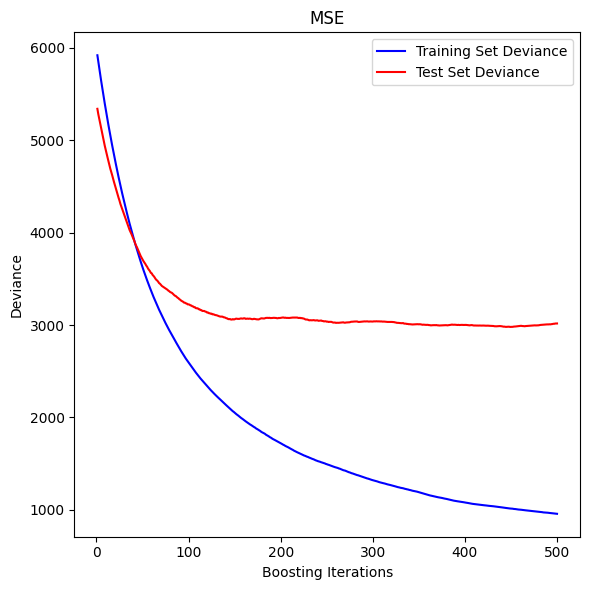

In [8]:

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
test_scores, train_scores = TrainFitPredict(reg, params['n_estimators'], X_train, y_train, X_test, y_test) #All datas are in ndarrays.
PlotPerformance(test_scores, train_scores)